In [2]:
# EDA
import sweetviz as sv
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.naive_bayes import GaussianNB
# Hyperparameter optimization
import optuna

In [3]:
# Data load

df_obesity = pd.read_csv("./datasets/ObesityDataSet_raw_and_data_sinthetic.csv")


In [4]:
df_obesity.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
df_obesity.describe(include='object')

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,2,2,2,4,2,2,4,5,7
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1726,1866,1765,2067,2015,1401,1580,351


In [6]:

df_obesity.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
# Change coluns to type int

coluns = ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

df_obesity[coluns] = df_obesity[coluns].astype(int)

In [8]:
df_obesity.NObeyesdad.value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

### EDA

In [9]:
# Distribution of the target variable

px.bar(df_obesity.value_counts("NObeyesdad"))

In [10]:
px.box(df_obesity, y="Age")

In [11]:
# univariate analysis

px.bar(df_obesity.value_counts("Gender"))

In [12]:
df_obesity.Age.describe()

count    2111.000000
mean       23.972525
std         6.308664
min        14.000000
25%        19.000000
50%        22.000000
75%        26.000000
max        61.000000
Name: Age, dtype: float64

In [13]:
# Age bucketing 

bins = [10, 20, 30, 40, 50, 60, 70]
bins_ordinal = [0, 1, 2, 3, 4, 5]
age_group_labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70']
df_obesity['age_group_string'] = pd.cut(x = df_obesity["Age"], bins = bins, labels=age_group_labels, include_lowest = True)
df_obesity['age_group'] = pd.cut(x = df_obesity["Age"], bins = bins, labels=bins_ordinal, include_lowest = True)

In [14]:
# Contingenny table
age_group_contigency_table = sm.stats.Table.from_data(df_obesity[["NObeyesdad", "age_group"]])

In [15]:
age_group_contigency_table.table_orig

age_group,0,1,2,3,4,5
NObeyesdad,,,,,,
Insufficient_Weight,198,71,3,0,0,0
Normal_Weight,132,137,16,0,1,1
Obesity_Type_I,92,177,66,15,1,0
Obesity_Type_II,8,224,61,4,0,0
Obesity_Type_III,76,248,0,0,0,0
Overweight_Level_I,99,151,37,2,1,0
Overweight_Level_II,69,130,75,11,5,0


In [16]:
df_obesity_eda = df_obesity.copy()
df_obesity_eda.drop(columns=['age_group_string', 'Age'], axis=1, inplace=True)

categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'MTRANS', 'CALC']

# Crie o objeto LabelEncoder
le = LabelEncoder()

# Aplique o LabelEncoder a cada coluna categórica
for column in categorical_columns:
    df_obesity_eda[column] = le.fit_transform(df_obesity_eda[column])
df_obesity_eda.head(10)


,Gender,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,age_group
0,0,1.62,64.0,1,0,2,3,2,0,2,0,0,1,3,3,Normal_Weight,1
1,0,1.52,56.0,1,0,3,3,2,1,3,1,3,0,2,3,Normal_Weight,1
2,1,1.80,77.0,1,0,2,3,2,0,2,0,2,1,1,3,Normal_Weight,1
3,1,1.80,87.0,0,0,3,3,2,0,2,0,2,0,1,4,Overweight_Level_I,1
4,1,1.78,89.8,0,0,2,1,2,0,2,0,0,0,2,3,Overweight_Level_II,1
5,1,1.62,53.0,0,1,2,3,2,0,2,0,0,0,2,0,Normal_Weight,1
6,0,1.50,55.0,1,1,3,3,2,0,2,0,1,0,2,2,Normal_Weight,1
7,1,1.64,53.0,0,0,2,3,2,0,2,0,3,0,2,3,Normal_Weight,1
8,1,1.78,64.0,1,1,3,3,2,0,2,0,1,1,1,3,Normal_Weight,1
9,1,1.72,68.0,1,1,2,3,2,0,2,0,1,1,3,3,Normal_Weight,1


In [17]:
# Aplique o OneHotEncoder a para coluna categórica nominal
niveisDiabetes = pd.get_dummies(df_obesity_eda[['NObeyesdad']], dtype='int')
df_obesity_eda = pd.concat([df_obesity_eda, niveisDiabetes], axis=1)


In [18]:
# transformação das variaveis categoricas para binária
df_obesity_eda['Gender'] = df_obesity_eda['Gender'].replace({'Female': 1, 'Male': 0})
df_obesity_eda[["family_history_with_overweight", 'FAVC', "SMOKE", "SCC"]] = df_obesity_eda[["family_history_with_overweight", 'FAVC', "SMOKE", "SCC"]].replace({'yes': 1, 'no':0})
df_obesity_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   int64   
 1   Height                          2111 non-null   float64 
 2   Weight                          2111 non-null   float64 
 3   family_history_with_overweight  2111 non-null   int64   
 4   FAVC                            2111 non-null   int64   
 5   FCVC                            2111 non-null   int64   
 6   NCP                             2111 non-null   int64   
 7   CAEC                            2111 non-null   int64   
 8   SMOKE                           2111 non-null   int64   
 9   CH2O                            2111 non-null   int64   
 10  SCC                             2111 non-null   int64   
 11  FAF                             2111 non-null   int64   
 12  TUE                 

In [19]:

# Chi-Square test
print(age_group_contigency_table.test_nominal_association())


df          30
pvalue      0.0
statistic   559.1519060218227


p_value < 0.05, rejeitamos H0, portanto as váriaveis não são independentes

In [20]:
df_obesity_eda.drop(columns=['NObeyesdad'], axis=1, inplace=True)


<Axes: >

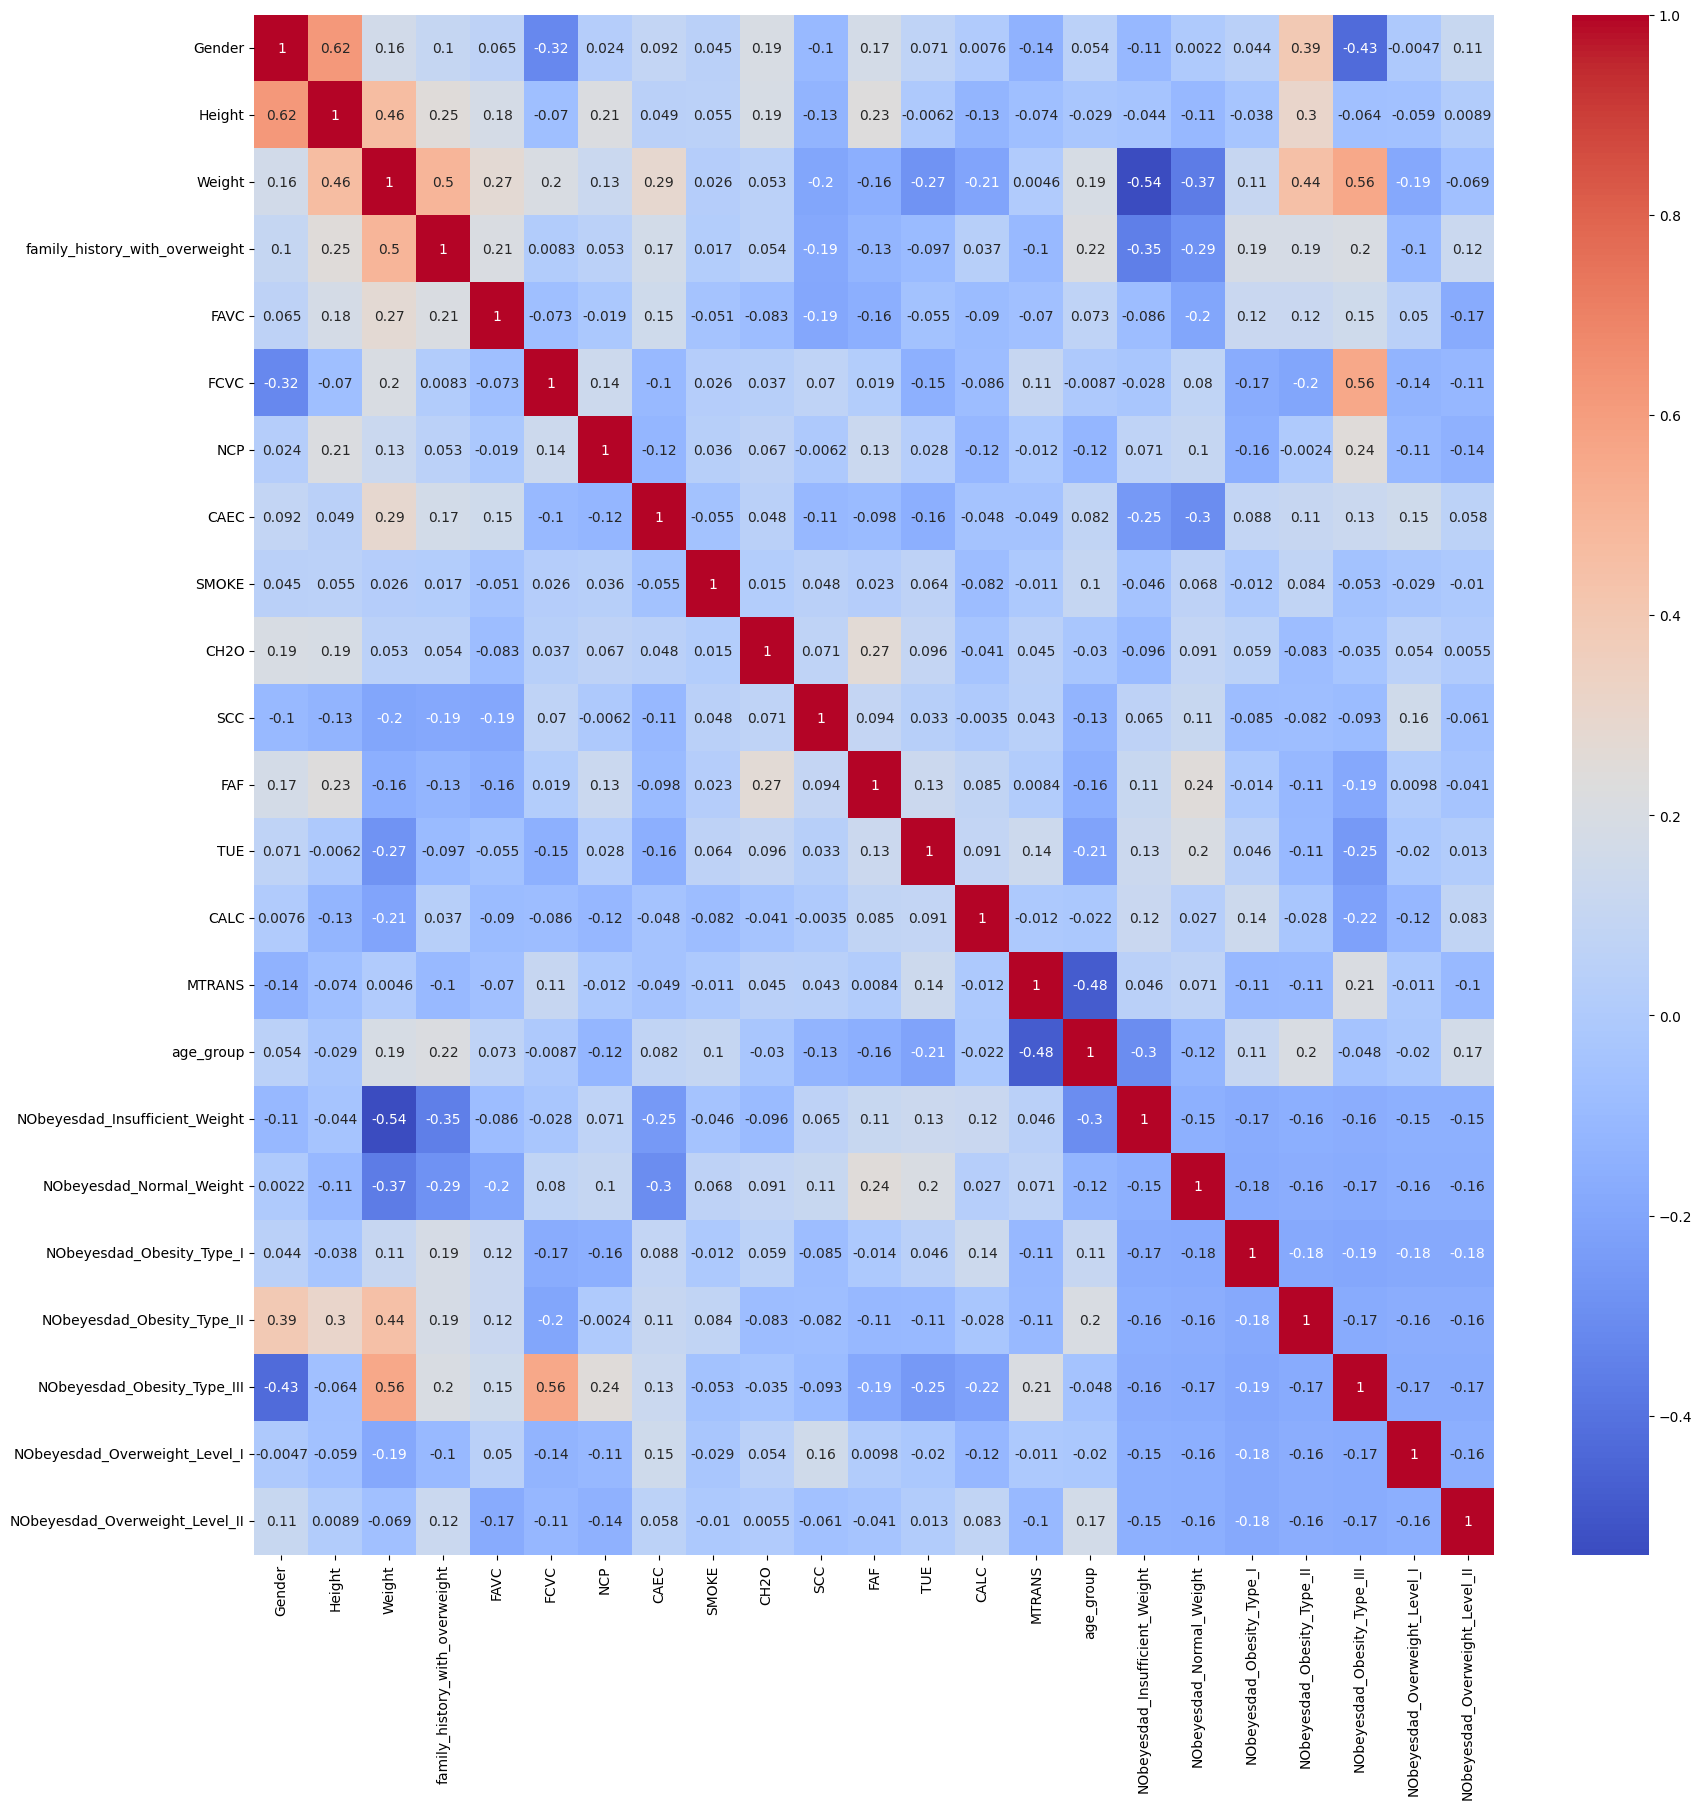

In [21]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_obesity_eda.corr(), annot=True, cmap='coolwarm')

### Treinamento do modelo - Baseline

In [22]:
colunas_categoricas_ordinais= ['family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'MTRANS', 'CALC', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'age_group'] 
colunas_numericas_continuas = ['Height', 'Weight']
colunas_categoricas_nominales = ['Gender']

tranformer_nominal = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
tranformer_ordinal = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
tranformer_continua = Pipeline(steps=[('continua', MinMaxScaler(feature_range=(0, 1)))])

preprocessor = ColumnTransformer(transformers=([('nom', tranformer_nominal, colunas_categoricas_nominales),
                                                ('ord', tranformer_ordinal, colunas_categoricas_ordinais), 
                                                ('nume', tranformer_continua, colunas_numericas_continuas)]))

In [23]:
X = df_obesity.drop(columns=['NObeyesdad', 'age_group_string', 'Age'], axis=1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_obesity['NObeyesdad'])
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True) 
# shuflle=True para embaralhar os dados

In [24]:
model_baseline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())])
model_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'MTRANS', 'CALC',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE', 'age_group']),
                                                 ('nume',
                                                  Pipeline(steps=[('continua',
                                                                   MinMaxScaler())]),
                                                  ['Height', 'Weight'])])),
                ('classifier', GaussianNB())])

### Métricas modelo baseline

In [25]:
# Predizer valores de conjunto de testes

y_pred = model_baseline.predict(X_test)

In [26]:
# Desempenho do modelo
classfication_report_str = classification_report(y_test, y_pred)
recall_baseline = recall_score(y_test, y_pred, average='macro')
print(f'Recall score: \n{recall_baseline}')
print(f'Relatório de classificação: \n{classfication_report_str}')


Recall score: 
0.6068928177072147
Relatório de classificação: 
              precision    recall  f1-score   support

           0       0.66      0.84      0.74        56
           1       0.67      0.35      0.46        62
           2       0.39      0.49      0.43        78
           3       0.58      0.97      0.72        58
           4       1.00      1.00      1.00        63
           5       0.49      0.32      0.39        56
           6       0.58      0.28      0.38        50

    accuracy                           0.61       423
   macro avg       0.62      0.61      0.59       423
weighted avg       0.62      0.61      0.59       423



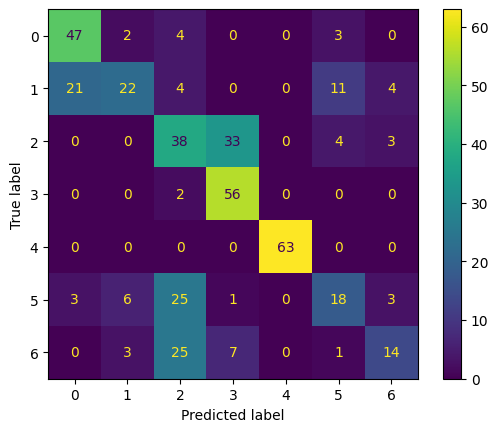

In [27]:
# matriz de confusão

confusion_matrix_modelo_baseline = confusion_matrix(y_test, y_pred)
disp_modelo_baseline = ConfusionMatrixDisplay(confusion_matrix_modelo_baseline)
disp_modelo_baseline.plot()

### Treinamento do modelo - Automated Feature selection

In [28]:
# Select Kbest - Seleção das k melhores features

kbest = SelectKBest(chi2, k=8)


In [29]:
X_train_transformed = preprocessor.fit_transform(X_train)

# Caso deseje retornar o resultado como um DataFrame (opcional, dependendo da aplicação)

# Capturando os nomes das colunas após a transformação
colunas_nominais_transformadas = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out(colunas_categoricas_nominales)
colunas_ordenadas_transformadas = colunas_categoricas_ordinais
colunas_continuas_transformadas = colunas_numericas_continuas

# Criando as colunas finais
colunas_finais = list(colunas_nominais_transformadas) + colunas_ordenadas_transformadas + colunas_continuas_transformadas

# Convertendo para DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=colunas_finais, index=X_train.index)

# Verificando o resultado


X_train_kbest = kbest.fit_transform(X_train_transformed, y_train)

In [30]:
kbest_features = kbest.get_support(indices=True)
X_train_kbest_features = X_train_transformed_df.iloc[:, kbest_features]

In [31]:
modelo_kbest = GaussianNB()
modelo_kbest.fit(X_train_kbest_features, y_train)

GaussianNB()

### Métricas modelo Select Kbest

In [32]:
X_test_transformed = preprocessor.fit_transform(X_test)

# Caso deseje retornar o resultado como um DataFrame (opcional, dependendo da aplicação)

# Capturando os nomes das colunas após a transformação
colunas_nominais_transformadas = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out(colunas_categoricas_nominales)
colunas_ordenadas_transformadas = colunas_categoricas_ordinais
colunas_continuas_transformadas = colunas_numericas_continuas

# Criando as colunas finais
colunas_finais = list(colunas_nominais_transformadas) + colunas_ordenadas_transformadas + colunas_continuas_transformadas

# Convertendo para DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=colunas_finais, index=X_test.index)

In [33]:
X_test_kbest = kbest.transform(X_test_transformed)

X_test_kbest_features = X_test_transformed_df.iloc[:, kbest_features]

In [34]:
# Predizer valores de conjunto de testes

y_pred_kbest = modelo_kbest.predict(X_test_kbest_features)

In [35]:
# Desempenho do modelo
classfication_report_str = classification_report(y_test, y_pred_kbest)
recall_baseline = recall_score(y_test, y_pred_kbest, average='macro')
print(f'Recall score: \n{recall_baseline}')
print(f'Relatório de classificação: \n{classfication_report_str}')


Recall score: 
0.5752113401191742
Relatório de classificação: 
              precision    recall  f1-score   support

           0       0.63      0.59      0.61        56
           1       0.54      0.42      0.47        62
           2       0.56      0.26      0.35        78
           3       0.53      1.00      0.69        58
           4       0.79      1.00      0.88        63
           5       0.47      0.32      0.38        56
           6       0.37      0.44      0.40        50

    accuracy                           0.57       423
   macro avg       0.56      0.58      0.54       423
weighted avg       0.56      0.57      0.54       423



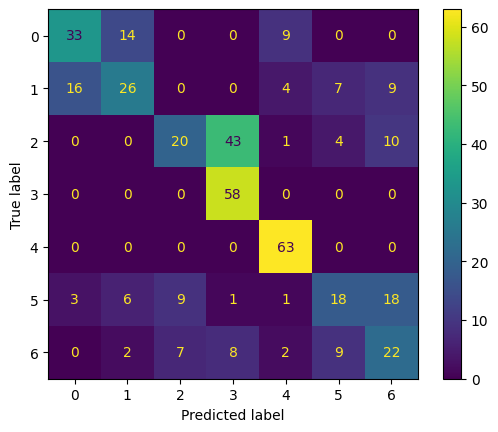

In [36]:
# matriz de confusão

confusion_matrix_modelo_kbest = confusion_matrix(y_test, y_pred_kbest)
disp_modelo_baseline = ConfusionMatrixDisplay(confusion_matrix_modelo_kbest)
disp_modelo_baseline.plot()

Notemos que o desempenho do modelo caiu ao trocar as features;

In [37]:
X_train_transformed_df

,Gender_Female,Gender_Male,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,MTRANS,CALC,FCVC,NCP,CH2O,FAF,TUE,age_group,Height,Weight
162,1.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,0.339623,0.156716
2001,1.0,0.0,1.0,1.0,2.0,0.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.570813,0.706110
1435,1.0,0.0,1.0,1.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.399462,0.325342
649,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,0.0,1.0,1.0,0.0,1.0,0.260464,0.039075
1280,0.0,1.0,1.0,1.0,2.0,0.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.682268,0.500314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0,0.575389,0.605215
1095,0.0,1.0,1.0,1.0,2.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.507511,0.318432
1130,1.0,0.0,1.0,1.0,2.0,0.0,0.0,3.0,3.0,1.0,2.0,1.0,0.0,2.0,1.0,0.377358,0.305970
1294,1.0,0.0,1.0,1.0,2.0,0.0,0.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.336166,0.339537


In [38]:
y_train

array([1, 4, 2, ..., 6, 2, 5])

# Tuning de Hiperparâmetros

In [39]:
# Ajuste de hiperparâmetros do SelectKbest
# k = k melhores features conforme chi2

def naivebayes_optuna(trial):
    k = trial.suggest_int('k', 1, 19)
    kbest = SelectKBest(chi2, k=k)
    X_test_kbest = kbest.fit_transform(X_train_transformed_df, y_train)
    kbest_features = kbest.get_support(indices=True)

    X_train_best_features = X_train_transformed_df.iloc[:, kbest_features]

    # Treinar modelo com melhores features
    modelo_kbest_optuna = GaussianNB()
    modelo_kbest_optuna.fit(X_train_best_features, y_train)

    # seletor de features no conjunto de teste

    X_test_kbest = kbest.transform(X_test_transformed_df)
    X_teste_best_features = X_test_transformed_df.iloc[:, kbest_features]

    # Predizer valores 
    y_pred_kbest = modelo_kbest_optuna.predict(X_teste_best_features)

    recall_optuna = recall_score(y_test, y_pred_kbest, average='macro')

    return k, recall_optuna


In [40]:
# Estudo dos hiperparâmetros

search_space = {'k': range(1,19)}

estudo_naivebayes = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space=search_space), directions=['minimize', 'maximize'])
estudo_naivebayes.optimize(naivebayes_optuna, n_trials=50)

[I 2024-11-23 17:16:47,893] A new study created in memory with name: no-name-acd0a71b-ffd8-4a5d-bd35-4a0a9d22426c
[I 2024-11-23 17:16:47,929] Trial 0 finished with values: [2.0, 0.2857142857142857] and parameters: {'k': 2}.
[I 2024-11-23 17:16:47,957] Trial 1 finished with values: [7.0, 0.5852488985668709] and parameters: {'k': 7}.
[I 2024-11-23 17:16:48,008] Trial 2 finished with values: [9.0, 0.5712229705778092] and parameters: {'k': 9}.
[I 2024-11-23 17:16:48,035] Trial 3 finished with values: [11.0, 0.548693050421161] and parameters: {'k': 11}.
[I 2024-11-23 17:16:48,087] Trial 4 finished with values: [15.0, 0.6123524452135608] and parameters: {'k': 15}.
[I 2024-11-23 17:16:48,129] Trial 5 finished with values: [5.0, 0.4063423136003781] and parameters: {'k': 5}.
[I 2024-11-23 17:16:48,163] Trial 6 finished with values: [3.0, 0.3435374149659864] and parameters: {'k': 3}.
[I 2024-11-23 17:16:48,190] Trial 7 finished with values: [17.0, 0.4592912207237648] and parameters: {'k': 17}.
c

In [41]:
# Resultado do estudo
trial_melhor_recall1 = max(estudo_naivebayes.best_trials, key=lambda t: t.values[1])
print("Melhor Recall e menor k:")
print(f"trial number: {trial_melhor_recall1.number}")
print(f"parametros: {trial_melhor_recall1.params}")
print(f"values: {trial_melhor_recall1.values}")



Melhor Recall e menor k:
trial number: 4
parametros: {'k': 15}
values: [15.0, 0.6123524452135608]


# Salvar Modelo

In [42]:
import joblib

joblib.dump(modelo_kbest, 'modelo_obsesity.pkl')

['modelo_obsesity.pkl']